<a href="https://colab.research.google.com/github/cagBRT/Diffusers/blob/main/stable_diffusion_seeds_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we learn to generate seeds that we can reuse to create the same image or an image with similar structure but with different content or style

**Install the necessary libraries**

In [ ]:
!pip install huggingface huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.4 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.20.2-py3-none-any.whl size=1342633 sha256=132c10e9ea1344855973eae08ea87c51e298c878edb8cab6ee2b1376783fa32f
  Stored in directory: /root/.cache/pip/wheels/dc/8b/d9/34f7a1936109e05e9bba0cc2241a6f8cd89e25959dc7aae942
Successfully built diffusers


In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git
!pip install transformers scipy ftfy

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-his1epqb
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-his1epqb
  Resolved https://github.com/huggingface/diffusers.git to commit 9800cc5ece794f8e63b61fb21e8f3197a88bc00f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.21.0.dev0-py3-none-any.whl size=1490589 sha256=e499c7c41d526424053605ae3eca2bd2df049dc4563e8e70093cd164af9e008c
  Stored in directory: /tmp/pip-ephem-wheel-cache-hvpz5sgc/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.20.2
    Uninstalling diffusers-0.20.2:
      Successfully uninstalled diffusers-0.20.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 5

In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.4 MB/s eta 0:00:00


In [ ]:
import torch
from diffusers import StableDiffusionPipeline

In [ ]:
#from huggingface_hub import login
from diffusers import DiffusionPipeline
import torch

**Login to HuggingFace, get a write token**

In [ ]:
#login()

**Setup the pipeline to use the stable-diffusion-vl-5 model**

In [ ]:
pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
device = "cuda"
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    revision="fp16",
    torch_dtype=torch.float16,
    #use_auth_token=True,
).to(device)

safety_checker/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


**A function to display the generated images**

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

**Set the constants**

In [ ]:
num_images = 4

width = 512
height = 512

# Latents Generation
In order to reuse the seeds we need to generate the latents ourselves. Otherwise, the pipeline will do it internally and we won't have a way to replicate them.

**Latents are the initial random Gaussian noise that gets transformed to actual images during the diffusion process.**

To generate them, we'll use a different random seed for each latent, and we'll save them so we can reuse them later.

In [ ]:
generator = torch.Generator(device=device)

latents = None
seeds = []
for _ in range(num_images):
    # Get a new random seed, store it and use it as the generator state
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)

    image_latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))

# latents should have shape (4, 4, 64, 64) in this case
latents.shape

<ipython-input-12-d39c707f0353>:12: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),


torch.Size([4, 4, 64, 64])

In [ ]:
seeds

[2680120891157354, 8735279902094979, 536287429306428, 4045315471414392]

# Generate Images with our Latents

We are now ready to generate the images. **We'll send the pipeline the latents we want to use. If we don't, the pipeline will generate a new set for us.**

In [ ]:
prompt = "Labrador in the style of Vermeer"

with torch.autocast("cuda"):
    images = pipe(
        [prompt] * num_images,
        guidance_scale=7.5,
        latents = latents,
    )[0]

  0%|          | 0/50 [00:00<?, ?it/s]

**Display the generated images**

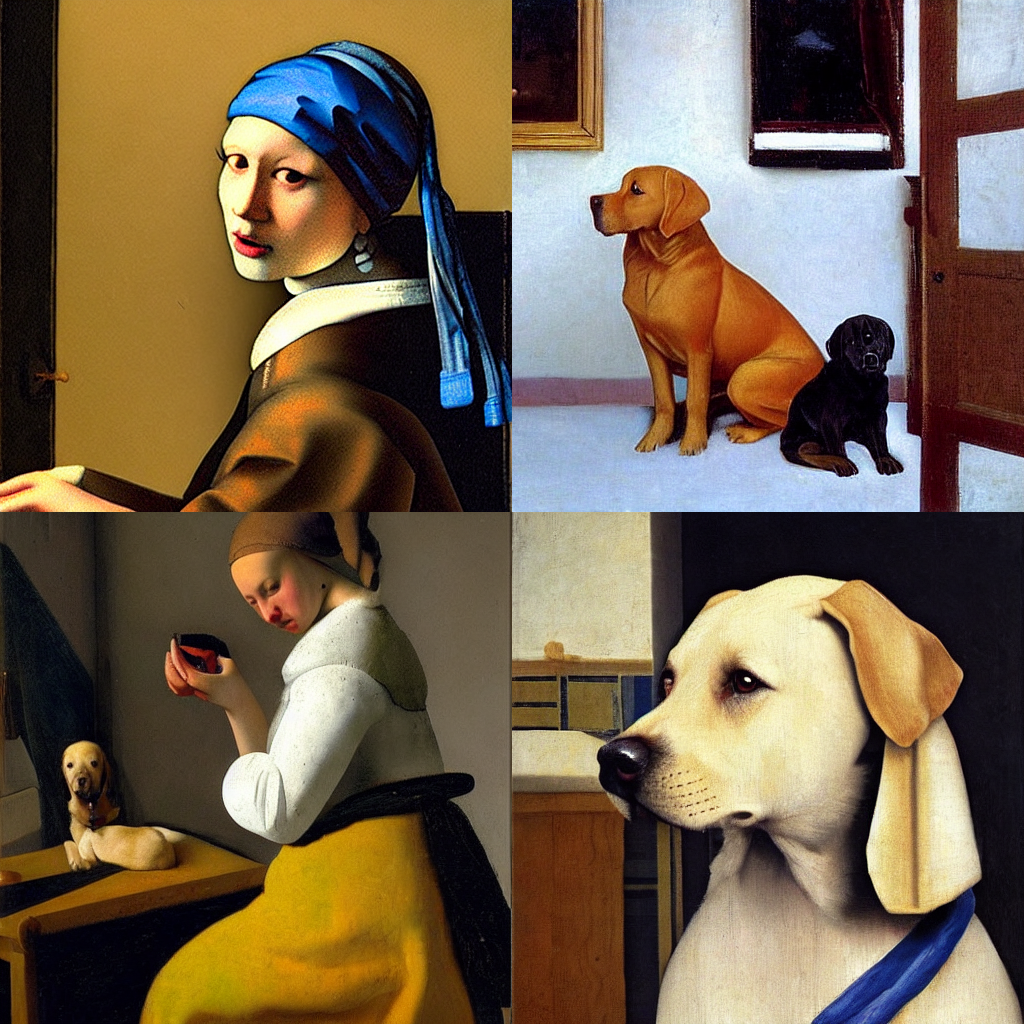

In [ ]:
image_grid(images, 2, 2)

**Get the seed for the fourth image**

In [ ]:
seed = seeds[3]   # fourth one
seed

4045315471414392

**We could just have reused `latents[3]` instead. But just taking note of the seeds will be enough te replicate the generation any time we like.**

In [ ]:
generator.manual_seed(seed)

latents = torch.randn(
    (1, pipe.unet.in_channels, height // 8, width // 8),
    generator = generator,
    device = device
)

<ipython-input-17-836d7e1e19fd>:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),


If we repeat the generation (of a single image) with these latents and the same prompt, we should get the same image as before:

  0%|          | 0/50 [00:00<?, ?it/s]

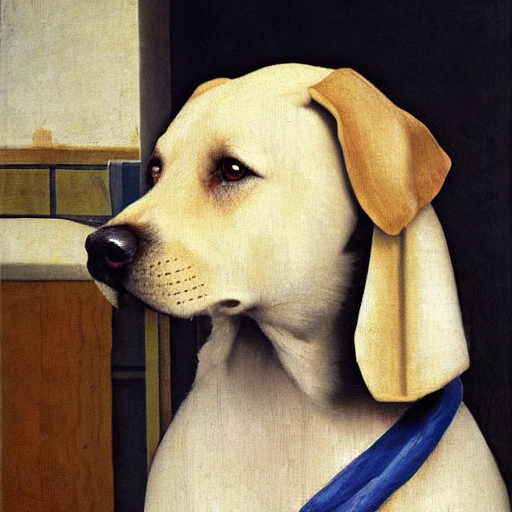

In [ ]:
with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    )[0]

image[0]

We can now try to tweak the prompt keeping the same latents. This should create an image with a similar structure but different content or style.

  0%|          | 0/50 [00:00<?, ?it/s]

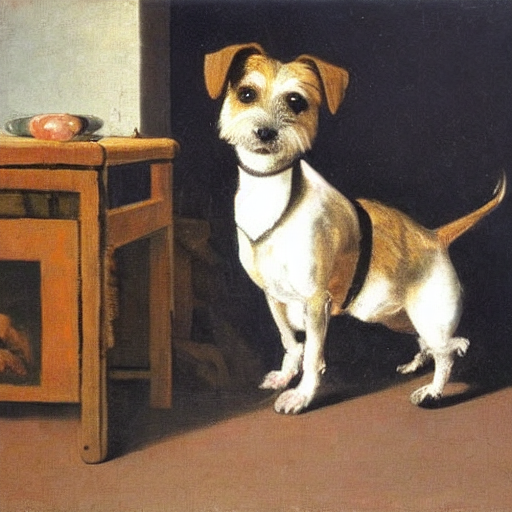

In [ ]:
prompt = "Terrier in the style of Vermeer"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    )[0]

image[0]

  0%|          | 0/50 [00:00<?, ?it/s]

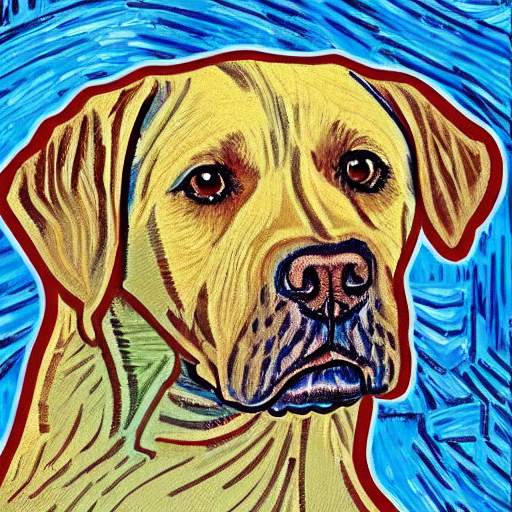

In [ ]:
prompt = "Labrador in the style of Van Gogh"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    )[0]

image[0]

  0%|          | 0/50 [00:00<?, ?it/s]

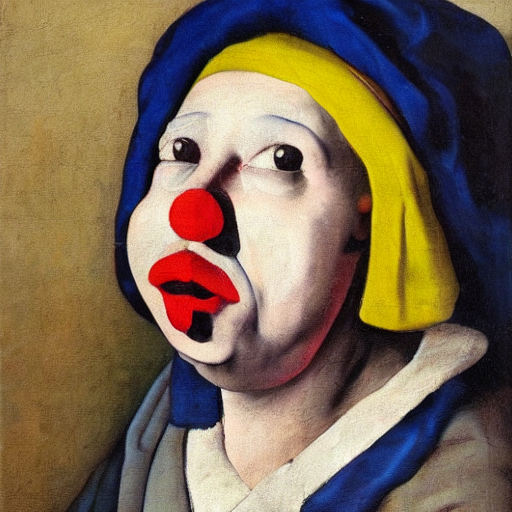

In [ ]:
prompt = "Clown in the style of Vermeer"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    )[0]

image[0]

**Assignment**<br>
1. Try different seeds and see the effect on the images
2. Try changing the guidance_scale (1-10). See the effect on the created images.